In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Fetch historical stock data
ticker = 'AAPL'  # Example: Apple stock
start_date = '2023-05-01'
end_date = pd.Timestamp.now().strftime('%Y-%m-%d')  # Current date
stock_data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
stock_data.tail()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-05-07,183.449997,184.899994,181.320007,182.399994,182.152924,77305800
2024-05-08,182.850006,183.070007,181.449997,182.740005,182.492477,45057100
2024-05-09,182.559998,184.660004,182.110001,184.570007,184.320007,48983000
2024-05-10,184.899994,185.089996,182.130005,183.050003,183.050003,50759500
2024-05-13,185.440002,187.100006,184.619995,186.279999,186.279999,71998100


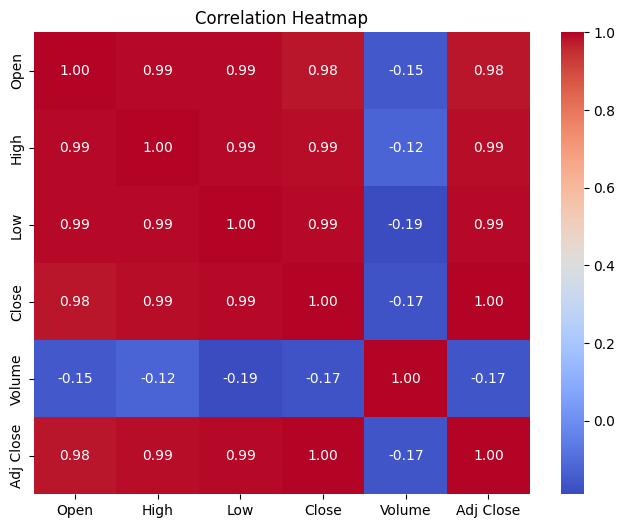

In [ ]:
correlation_matrix = stock_data[['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# Stationarity check and PACF test
for column in ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']:
    # Check stationarity
    result = adfuller(stock_data[column])
    print(f'ADF Statistic for {column}: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Stationary' if result[1] < 0.05 else 'Non-Stationary')

ADF Statistic for Open: -2.533975679589339
p-value: 0.10742497079407587
Non-Stationary
ADF Statistic for High: -2.6100069773410057
p-value: 0.09094661648987523
Non-Stationary
ADF Statistic for Low: -2.6800072258600416
p-value: 0.07756224679403487
Non-Stationary
ADF Statistic for Close: -2.6273819011926904
p-value: 0.08746900290906345
Non-Stationary
ADF Statistic for Volume: -10.871144951047551
p-value: 1.3674970849650987e-19
Stationary
ADF Statistic for Adj Close: -2.647983613515954
p-value: 0.0834799015619383
Non-Stationary


In [ ]:
# Convert non-stationary variables to stationary by differencing
stationary_data = stock_data.diff().dropna()

# Check stationarity of differenced data
for column in stationary_data.columns:
    result = adfuller(stationary_data[column])
    print(f'ADF Statistic for {column}: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Stationary' if result[1] < 0.05 else 'Non-Stationary')

ADF Statistic for Open: -15.694997598058666
p-value: 1.418683082483431e-28
Stationary
ADF Statistic for High: -14.528123160710086
p-value: 5.3865046676832445e-27
Stationary
ADF Statistic for Low: -13.831628461318449
p-value: 7.573678636782914e-26
Stationary
ADF Statistic for Close: -14.558125936221185
p-value: 4.843638424506423e-27
Stationary
ADF Statistic for Adj Close: -14.557783435074235
p-value: 4.849498095607943e-27
Stationary
ADF Statistic for Volume: -9.29387464375063
p-value: 1.1601248119278967e-15
Stationary


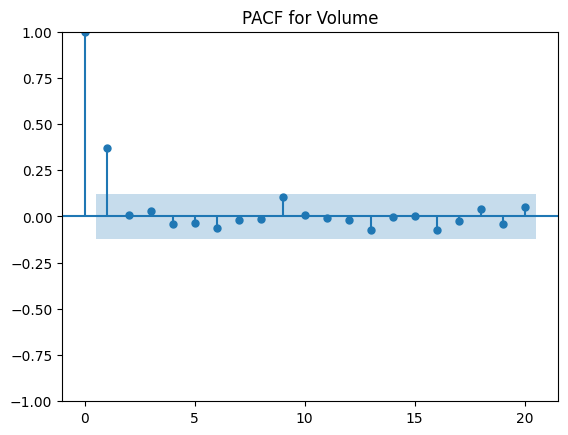

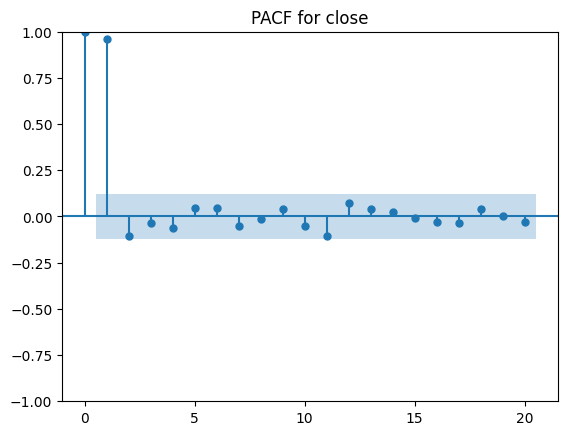

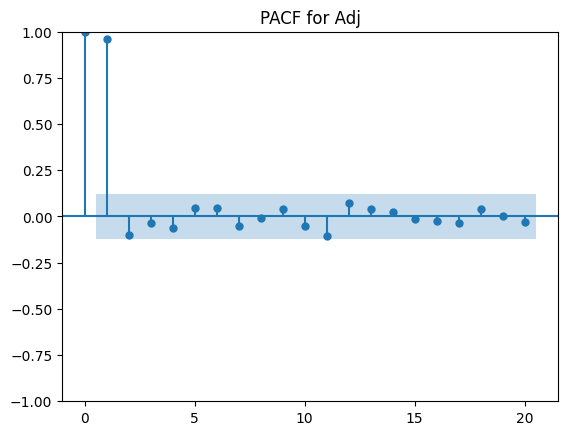

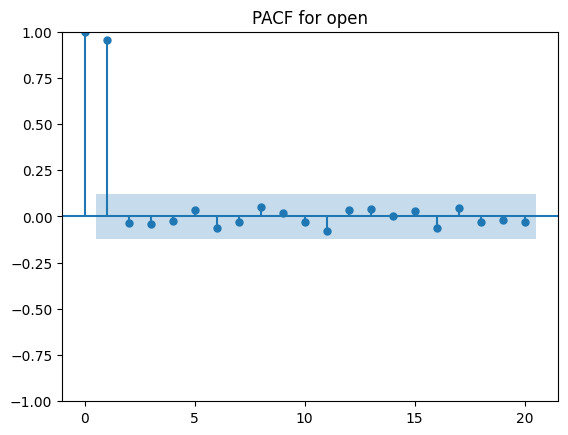

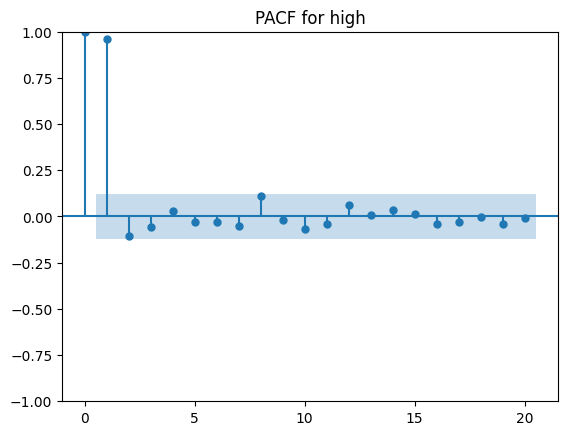

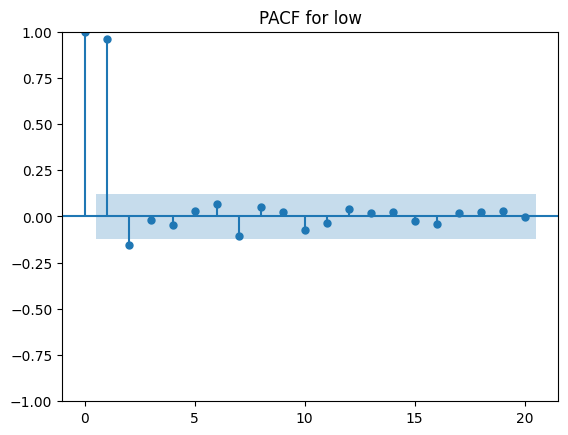

In [ ]:
 # PACF test
plot_pacf(stock_data['Volume'], lags=20)
plt.title('PACF for Volume')
plt.show()
plot_pacf(stock_data['Close'], lags=20)
plt.title('PACF for close')
plt.show()
plot_pacf(stock_data['Adj Close'], lags=20)
plt.title('PACF for Adj')
plt.show()
plot_pacf(stock_data['Open'], lags=20)
plt.title('PACF for open')
plt.show()
plot_pacf(stock_data['High'], lags=20)
plt.title('PACF for high')
plt.show()
plot_pacf(stock_data['Low'], lags=20)
plt.title('PACF for low')
plt.show()

In [ ]:
train_data, test_data = train_test_split(stationary_data, test_size=0.05, shuffle=False)

In [ ]:
# Standardize data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data[['Open', 'High', 'Low', 'Close','Adj Close']])
test_scaled = scaler.transform(test_data[['Open', 'High', 'Low', 'Close','Adj Close']])
train_scaled

array([[0.65225488, 0.58882699, 0.49934882, 0.47936241, 0.47974876],
       [0.58716914, 0.62625619, 0.54622489, 0.47700431, 0.47739474],
       [0.40027907, 0.37765313, 0.38541653, 0.4433954 , 0.44381222],
       ...,
       [0.58251985, 0.64245777, 0.61588583, 0.59080101, 0.59137042],
       [0.60669486, 0.58268171, 0.58072902, 0.60377277, 0.60440213],
       [0.6699206 , 0.72011133, 0.65494873, 0.6662735 , 0.66718948]])

In [ ]:
train_scaled_df = pd.DataFrame(train_scaled, index=train_data.index, columns=['Open', 'High', 'Low', 'Close','Adj Close'])
test_scaled_df = pd.DataFrame(test_scaled, index=test_data.index, columns=['Open', 'High', 'Low', 'Close','Adj Close'])
# Add Volume back to the scaled dataframes
train_scaled_df['Volume'] = train_data['Volume']
test_scaled_df['Volume'] = test_data['Volume']
train_scaled_df


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-05-02,0.652255,0.588827,0.499349,0.479362,0.479749,-4047200.0
2023-05-03,0.587169,0.626256,0.546225,0.477004,0.477395,16710300.0
2023-05-04,0.400279,0.377653,0.385417,0.443395,0.443812,16099400.0
2023-05-05,0.897722,1.000000,0.990885,1.000000,1.000000,32081000.0
2023-05-08,0.684333,0.569274,0.658855,0.537145,0.537490,-57353600.0
...,...,...,...,...,...,...
2024-04-18,0.541144,0.482123,0.476563,0.484669,0.484752,-7778300.0
2024-04-19,0.529987,0.469273,0.410156,0.420990,0.420782,24649200.0
2024-04-22,0.582520,0.642458,0.615886,0.590801,0.591370,-19655700.0


In [ ]:
# Define VARMAX model
model = VARMAX(train_scaled_df[['Open', 'High', 'Low', 'Close', 'Adj Close']], exog=train_scaled_df['Volume'], order=(1, 1))
varmax_results = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# Predictions for open, high, low, close prices
varmax_forecast = varmax_results.forecast(steps=len(test_scaled_df), exog=test_scaled_df['Volume'])
varmax_forecast.index = test_scaled_df.index
varmax_forecast

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q

,Open,High,Low,Close,Adj Close
Date,,,,,
2024-04-25,0.688131,0.629634,0.635011,0.548948,0.549483
2024-04-26,0.601139,0.586066,0.568868,0.550720,0.551280
2024-04-29,0.615891,0.635327,0.540989,0.530411,0.530928
2024-04-30,0.609773,0.562430,0.574116,0.537143,0.537759
2024-05-01,0.615889,0.585295,0.591425,0.550421,0.550959
2024-05-02,0.605629,0.667415,0.503572,0.522469,0.522957
2024-05-03,0.587390,0.638362,0.470610,0.497668,0.498227
2024-05-06,0.623107,0.417167,0.697439,0.568360,0.569117
2024-05-07,0.619868,0.705685,0.559110,0.562955,0.563278


In [ ]:
open_pred = varmax_forecast['Open']
high_pred = varmax_forecast['High']
low_pred = varmax_forecast['Low']
close_pred = varmax_forecast['Close']
adjclose_pred = varmax_forecast['Adj Close']

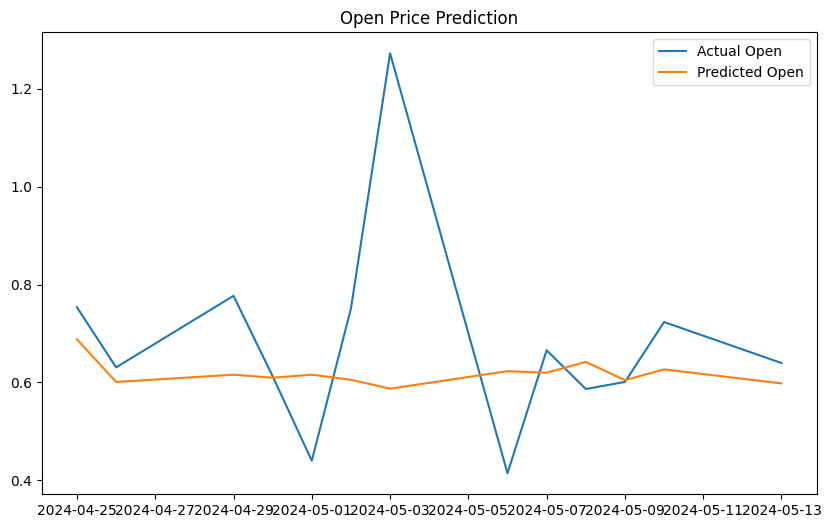

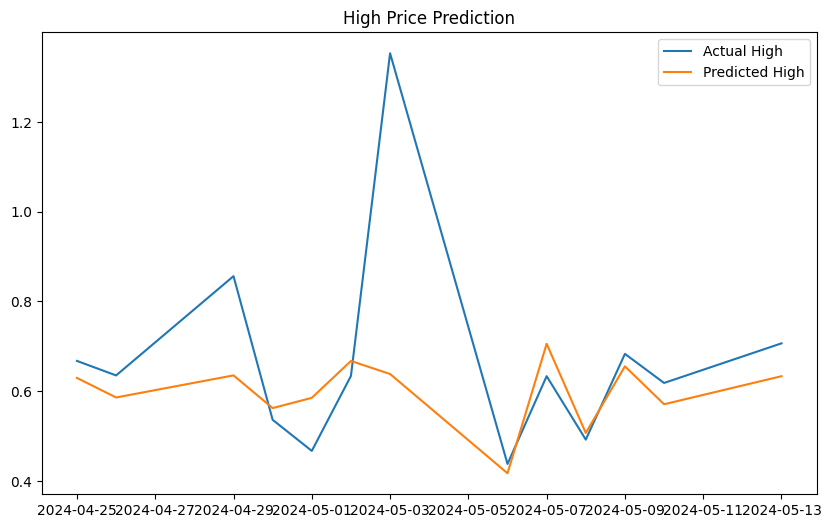

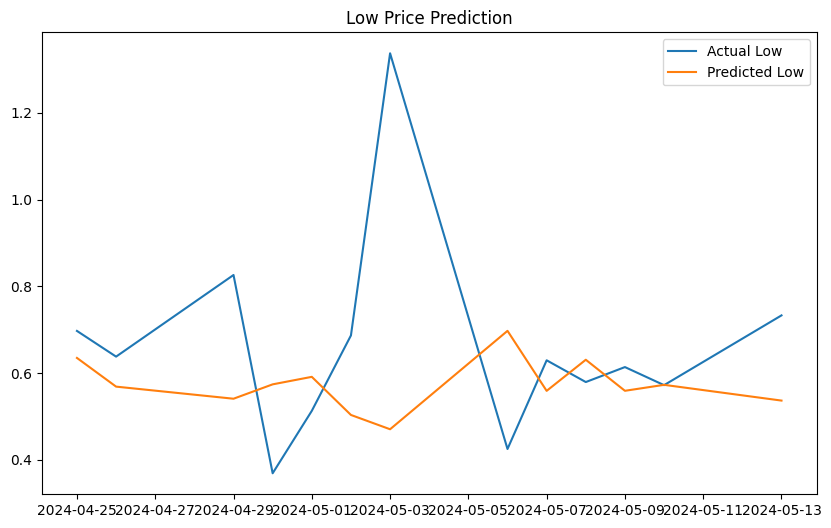

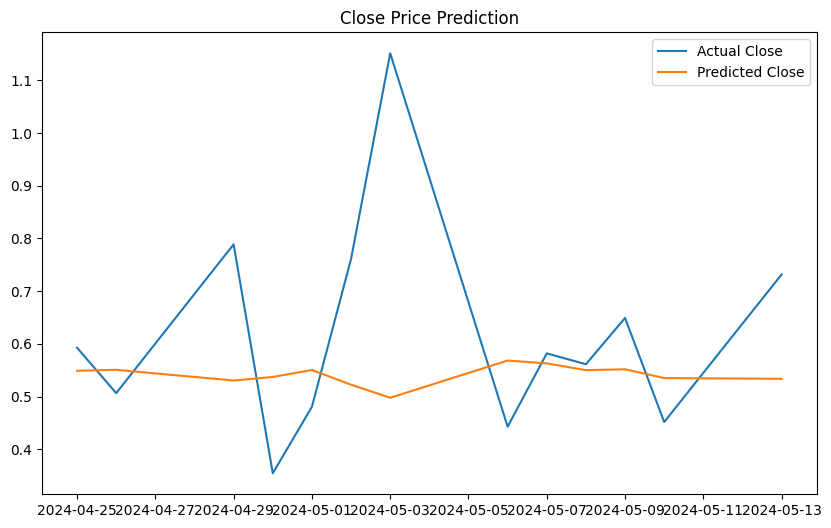

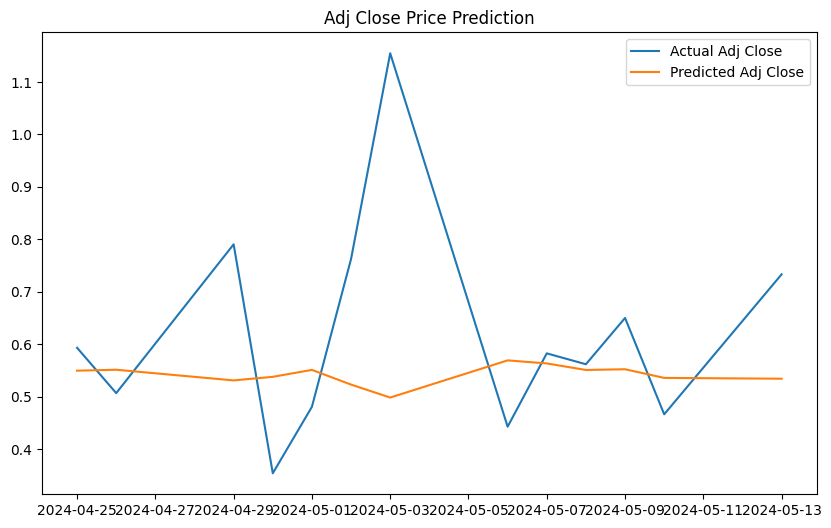

In [ ]:
# prompt: plot open_pred with test_scaled_df['Open'] and for others too

# Plot the predicted values against the actual values
plt.figure(figsize=(10, 6))
plt.plot(test_scaled_df['Open'], label='Actual Open')
plt.plot(open_pred, label='Predicted Open')
plt.title('Open Price Prediction')
plt.legend()
plt.show()

# Repeat for other columns
plt.figure(figsize=(10, 6))
plt.plot(test_scaled_df['High'], label='Actual High')
plt.plot(high_pred, label='Predicted High')
plt.title('High Price Prediction')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(test_scaled_df['Low'], label='Actual Low')
plt.plot(low_pred, label='Predicted Low')
plt.title('Low Price Prediction')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(test_scaled_df['Close'], label='Actual Close')
plt.plot(close_pred, label='Predicted Close')
plt.title('Close Price Prediction')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(test_scaled_df['Adj Close'], label='Actual Adj Close')
plt.plot(adjclose_pred, label='Predicted Adj Close')
plt.title('Adj Close Price Prediction')
plt.legend()
plt.show()


In [ ]:


from sklearn.metrics import mean_squared_error

mse_open = mean_squared_error(test_scaled_df['Open'], open_pred)
mse_high = mean_squared_error(test_scaled_df['High'], high_pred)
mse_low = mean_squared_error(test_scaled_df['Low'], low_pred)
mse_close = mean_squared_error(test_scaled_df['Close'], close_pred)
mse_adjclose = mean_squared_error(test_scaled_df['Adj Close'], adjclose_pred)

print(f'MSE for open: {mse_open}')
print(f'MSE for high: {mse_high}')
print(f'MSE for low: {mse_low}')
print(f'MSE for close: {mse_close}')
print(f'MSE for adj close: {mse_adjclose}')


MSE for open: 0.04702552913428971
MSE for high: 0.04565879936167649
MSE for low: 0.08046904494408368
MSE for close: 0.05118515356832825
MSE for adj close: 0.05144531160626972


In [ ]:
# prompt: find the accuracy too in percent

accuracy_open = 100 - (mse_open / np.mean(test_scaled_df['Open']) * 100)
accuracy_high = 100 - (mse_high / np.mean(test_scaled_df['High']) * 100)
accuracy_low = 100 - (mse_low / np.mean(test_scaled_df['Low']) * 100)
accuracy_close = 100 - (mse_close / np.mean(test_scaled_df['Close']) * 100)
accuracy_adjclose = 100 - (mse_adjclose / np.mean(test_scaled_df['Adj Close']) * 100)

print(f'Accuracy for open: {accuracy_open:.2f}%')
print(f'Accuracy for high: {accuracy_high:.2f}%')
print(f'Accuracy for low: {accuracy_low:.2f}%')
print(f'Accuracy for close: {accuracy_close:.2f}%')
print(f'Accuracy for adj close: {accuracy_adjclose:.2f}%')


Accuracy for open: 93.11%
Accuracy for high: 93.19%
Accuracy for low: 87.87%
Accuracy for close: 91.74%
Accuracy for adj close: 91.72%


In [ ]:

# Concatenate the predicted values to the scaled train data
train_scaled_with_predictions = pd.concat([train_scaled_df, varmax_forecast], axis=0)
train_scaled_with_predictions.tail()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-05-07,0.619868,0.705685,0.559110,0.562955,0.563278,NaN
2024-05-08,0.642029,0.506967,0.630840,0.550074,0.550836,NaN
2024-05-09,0.604787,0.655510,0.559258,0.551806,0.552193,NaN
2024-05-10,0.626775,0.570997,0.572977,0.535049,0.535714,NaN
2024-05-13,0.598142,0.633508,0.536700,0.533700,0.534167,NaN


In [ ]:
max_close = max(train_data['Close'])
min_close = min(train_data['Close'])
max_low = max(train_data['Low'])
min_low = min(train_data['Low'])
max_high = max(train_data['High'])
min_high = min(train_data['High'])
max_adjclose = max(train_data['Adj Close'])
min_adjclose = min(train_data['Adj Close'])
max_open = max(train_data['Open'])
min_open = min(train_data['Open'])

In [ ]:
def descaler(z, min_value, max_value):
  """
  Descales the data back to its original scale.

  Args:
    z: The scaled value.
    min_value: The minimum value of the original data.
    max_value: The maximum value of the original data.

  Returns:
    The descaled value.
  """
  return (z * (max_value - min_value)) + min_value


In [ ]:
descaled_varmax_forecast = pd.DataFrame()
for column in varmax_forecast.columns:
  descaled_column = []
  for value in varmax_forecast[column]:
    if column == 'Open':
      descaled_column.append(descaler(value, min_open, max_open))
    elif column == 'High':
      descaled_column.append(descaler(value, min_high, max_high))
    elif column == 'Low':
      descaled_column.append(descaler(value, min_low, max_low))
    elif column == 'Close':
      descaled_column.append(descaler(value, min_close, max_close))
    elif column == 'Adj Close':
      descaled_column.append(descaler(value, min_adjclose, max_adjclose))
  descaled_varmax_forecast[column] = descaled_column

descaled_varmax_forecast.head(20)


,Open,High,Low,Close,Adj Close
0,1.581700,0.630451,0.983772,0.130167,0.132640
1,-0.289503,-0.149404,-0.032190,0.160229,0.162938
2,0.027810,0.732367,-0.460410,-0.184210,-0.180196
3,-0.103793,-0.572498,0.048421,-0.070052,-0.065025
4,0.027763,-0.163221,0.314285,0.155146,0.157526
5,-0.192927,1.306732,-1.035144,-0.318922,-0.314584
6,-0.585249,0.786681,-1.541428,-0.739546,-0.731519
7,0.183027,-3.172698,1.942658,0.459400,0.463671
8,0.113365,1.991761,-0.182071,0.367723,0.365214
9,0.590028,-1.565279,0.919702,0.149266,0.155448


In [ ]:
stock_train_data, stock_test_data = train_test_split(stock_data, test_size=0.05, shuffle=False)
stock_train_data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-17,169.610001,170.649994,168.000000,168.000000,167.772446,50901200
2024-04-18,168.029999,168.639999,166.550003,167.039993,166.813736,43122900
2024-04-19,166.210007,166.399994,164.080002,165.000000,164.776505,67772100
2024-04-22,165.520004,167.259995,164.770004,165.839996,165.615356,48116400
2024-04-23,165.350006,167.050003,164.919998,166.899994,166.673920,49537800


In [ ]:
def reverse_differencing_2d(stationary_data, last_train_values):
    """
    Reverts the differenced stationary data back to the original non-stationary form for a 2D matrix.

    Parameters:
    - stationary_data: 2D list or numpy array of differenced data (rows of predictions, columns of features).
    - last_train_values: 1D list or numpy array of the last values from the training data for each column.

    Returns:
    - non_stationary_data: 2D list of data in the original non-stationary form.
    """
    # Convert stationary_data to a numpy array if it's not already
    stationary_data = np.array(stationary_data)

    # Initialize the non-stationary data with the last train values
    non_stationary_data = [last_train_values]

    # Iterate over the rows in the stationary data
    for row in stationary_data:
        new_row = non_stationary_data[-1] + row
        non_stationary_data.append(new_row)

    # Convert list to a numpy array and remove the first row (initial last_train_values)
    non_stationary_data = np.array(non_stationary_data[1:])

    return non_stationary_data
last_train_values = [165.350006, 167.050003, 164.919998, 166.899994, 166.673920]

# Revert the differencing
original_form_predictions = reverse_differencing_2d(descaled_varmax_forecast, last_train_values)

# Convert to DataFrame for better readability (optional)
original_form_predictions_df = pd.DataFrame(original_form_predictions, columns=['Open', 'High', 'Low', 'Close', 'Adj Close'])

original_form_predictions_df.index = test_data.index
print(original_form_predictions_df)


                  Open        High         Low       Close   Adj Close
Date                                                                  
2024-04-25  166.931706  167.680454  165.903770  167.030161  166.806560
2024-04-26  166.642203  167.531050  165.871581  167.190391  166.969497
2024-04-29  166.670014  168.263417  165.411171  167.006181  166.789301
2024-04-30  166.566221  167.690919  165.459591  166.936128  166.724276
2024-05-01  166.593984  167.527698  165.773876  167.091275  166.881803
2024-05-02  166.401057  168.834430  164.738732  166.772352  166.567219
2024-05-03  165.815807  169.621111  163.197304  166.032806  165.835700
2024-05-06  165.998835  166.448413  165.139962  166.492206  166.299371
2024-05-07  166.112199  168.440174  164.957891  166.859929  166.664586
2024-05-08  166.702227  166.874895  165.877593  167.009194  166.820034
2024-05-09  166.491189  167.968528  165.697789  167.187832  166.998369
2024-05-10  166.753110  167.549385  165.728716  167.082274  166.898873
2024-0

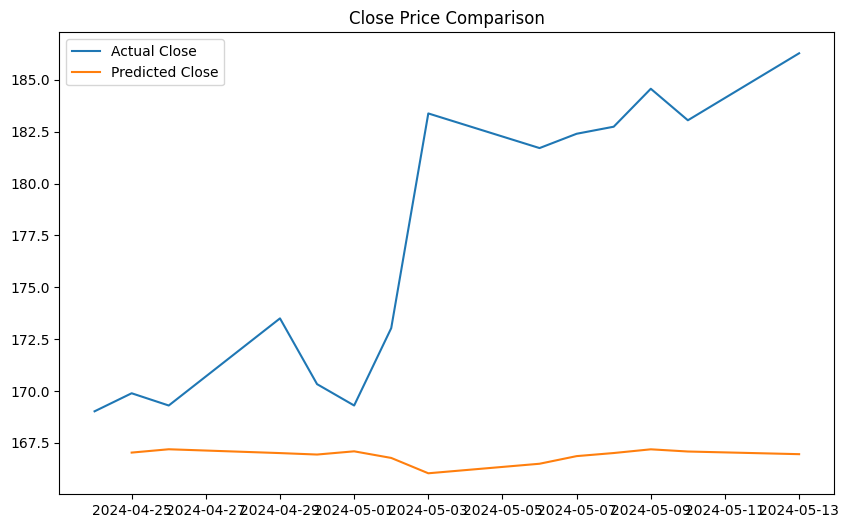

In [ ]:
import matplotlib.pyplot as plt

# Plot the actual and predicted close prices
plt.figure(figsize=(10, 6))
plt.plot(stock_test_data['Close'], label='Actual Close')
plt.plot(original_form_predictions_df['Close'], label='Predicted Close')
plt.title('Close Price Comparison')
plt.legend()
plt.show()


In [ ]:
train_data['Volume']

Date
2023-05-02    -4047200.0
2023-05-03    16710300.0
2023-05-04    16099400.0
2023-05-05    32081000.0
2023-05-08   -57353600.0
                 ...    
2024-04-18    -7778300.0
2024-04-19    24649200.0
2024-04-22   -19655700.0
2024-04-23     1421400.0
2024-04-24    -1286000.0
Name: Volume, Length: 247, dtype: float64

Epoch 1/10
16/16 - 5s - loss: 0.1834 - 5s/epoch - 328ms/step
Epoch 2/10
16/16 - 0s - loss: 0.1074 - 101ms/epoch - 6ms/step
Epoch 3/10
16/16 - 0s - loss: 0.0332 - 97ms/epoch - 6ms/step
Epoch 4/10
16/16 - 0s - loss: 0.0075 - 60ms/epoch - 4ms/step
Epoch 5/10
16/16 - 0s - loss: 0.0068 - 62ms/epoch - 4ms/step
Epoch 6/10
16/16 - 0s - loss: 0.0059 - 63ms/epoch - 4ms/step
Epoch 7/10
16/16 - 0s - loss: 0.0055 - 58ms/epoch - 4ms/step
Epoch 8/10
16/16 - 0s - loss: 0.0051 - 61ms/epoch - 4ms/step
Epoch 9/10
16/16 - 0s - loss: 0.0047 - 69ms/epoch - 4ms/step
Epoch 10/10
16/16 - 0s - loss: 0.0043 - 59ms/epoch - 4ms/step
1/1 [==============================] - 1s 801ms/step


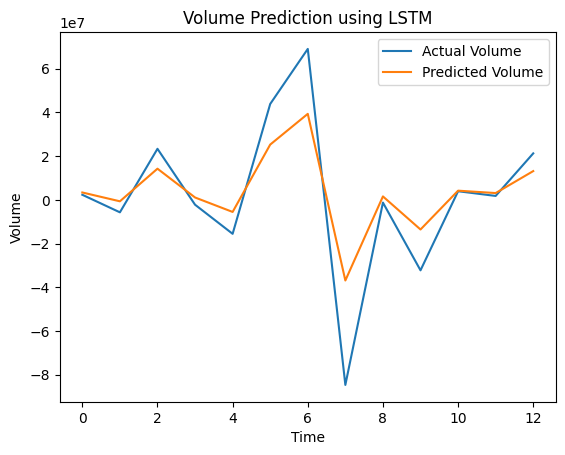

In [ ]:

# Prepare the data
volume_train = train_data['Volume'].values
volume_test = test_data['Volume'].values

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
volume_train_scaled = scaler.fit_transform(volume_train.reshape(-1, 1))
volume_test_scaled = scaler.transform(volume_test.reshape(-1, 1))

# Create the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(volume_train_scaled.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
history = model.fit(volume_train_scaled, volume_train_scaled, epochs=10, batch_size=16, verbose=2)

# Make predictions
predictions = model.predict(volume_test_scaled)

# Inverse transform the predictions
predictions = scaler.inverse_transform(predictions)

# Plot the results
plt.plot(volume_test, label='Actual Volume')
plt.plot(predictions, label='Predicted Volume')
plt.title('Volume Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Volume')
plt.legend()
plt.show()


In [ ]:
# prompt: convert this prediction to non stationary using reverse differencing

def reverse_differencing(stationary_data, last_train_value):
    non_stationary_data = [last_train_value]
    for row in stationary_data:
        new_row = non_stationary_data[-1] + row
        non_stationary_data.append(new_row)
    return non_stationary_data

last_train_value = stock_train_data['Volume'].iloc[-1]
non_stationary_predictions = reverse_differencing(predictions, last_train_value)
#non_stationary_predictions.index = test_data.index
non_stationary_predictions

[49537800,
 array([52894969.]),
 array([52212552.0625]),
 array([66451982.0625]),
 array([67515779.3125]),
 array([61973231.8125]),
 array([87231623.8125]),
 array([1.26548148e+08]),
 array([89654643.8125]),
 array([91206947.8125]),
 array([77635750.8125]),
 array([81815709.0625]),
 array([84904151.0625]),
 array([98041330.0625])]

In [ ]:
# prompt: remove the first element of non_stationary_predictions

non_stationary_predictions = non_stationary_predictions[1:]


In [ ]:
# Convert the list to a NumPy array
non_stationary_predictions = np.array([np.array(row) for row in non_stationary_predictions])

# Create a Pandas DataFrame
df = pd.DataFrame(data=non_stationary_predictions, index=test_data.index)

# Display the DataFrame
print(df)

                       0
Date                    
2024-04-25  5.289497e+07
2024-04-26  5.221255e+07
2024-04-29  6.645198e+07
2024-04-30  6.751578e+07
2024-05-01  6.197323e+07
2024-05-02  8.723162e+07
2024-05-03  1.265481e+08
2024-05-06  8.965464e+07
2024-05-07  9.120695e+07
2024-05-08  7.763575e+07
2024-05-09  8.181571e+07
2024-05-10  8.490415e+07
2024-05-13  9.804133e+07


In [ ]:
#original_form_predictions_df['Volume'] = df['Volume']
df = pd.DataFrame(df)
original_form_predictions_df = pd.DataFrame(original_form_predictions_df)
original_form_predictions_df['Volume'] = df[0]

In [ ]:
original_form_predictions_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-25,166.931706,167.680454,165.903770,167.030161,166.806560,5.289497e+07
2024-04-26,166.642203,167.531050,165.871581,167.190391,166.969497,5.221255e+07
2024-04-29,166.670014,168.263417,165.411171,167.006181,166.789301,6.645198e+07
2024-04-30,166.566221,167.690919,165.459591,166.936128,166.724276,6.751578e+07
2024-05-01,166.593984,167.527698,165.773876,167.091275,166.881803,6.197323e+07
2024-05-02,166.401057,168.834430,164.738732,166.772352,166.567219,8.723162e+07
2024-05-03,165.815807,169.621111,163.197304,166.032806,165.835700,1.265481e+08
2024-05-06,165.998835,166.448413,165.139962,166.492206,166.299371,8.965464e+07
2024-05-07,166.112199,168.440174,164.957891,166.859929,166.664586,9.120695e+07
